Turning the raw image into monochrome black & white image:

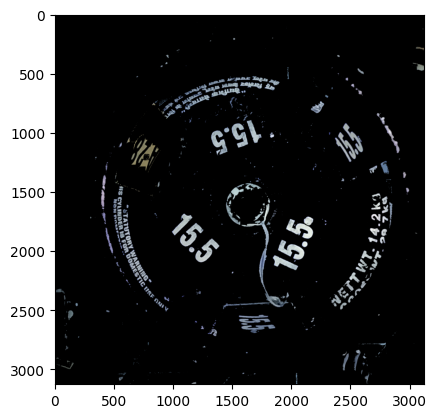

In [221]:
import sys

import cv2
import numpy as np
from matplotlib import pyplot as plt
import pytesseract

sys.path.append('..')
pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract.exe'

from shared import getMonochromeImage

loadedImage = cv2.imread('../images/Cylinder_image2.jpg')
image = getMonochromeImage(loadedImage)
plt.imshow(image)

Cropping the image to the closest  region where the number is:

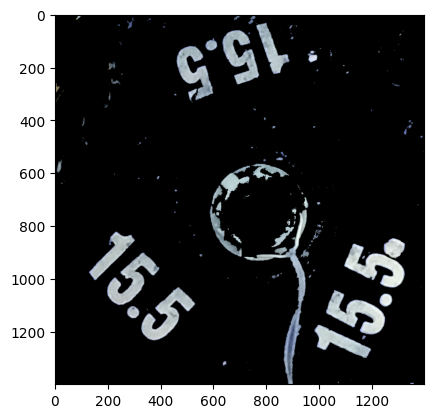

In [222]:
def getCroppedImage(image):
    image_height, image_width, _ = image.shape

    # Define the desired width and height of the crop
    crop_width = 1400
    crop_height = 1400

    # Calculate the coordinates for cropping the center region
    x1 = int(image_width/2 - crop_width/2)
    y1 = int(image_height/2 - crop_height/2)
    x2 = int(image_width/2 + crop_width/2)
    y2 = int(image_height/2 + crop_height/2)

    cropped_image = image[y1:y2, x1:x2]
    return cropped_image

cropped_image = getCroppedImage(image)
originalImage = cropped_image.copy()
plt.imshow(cropped_image)

Box the region where the numbers are located. Get the contour of these boxes in a list.

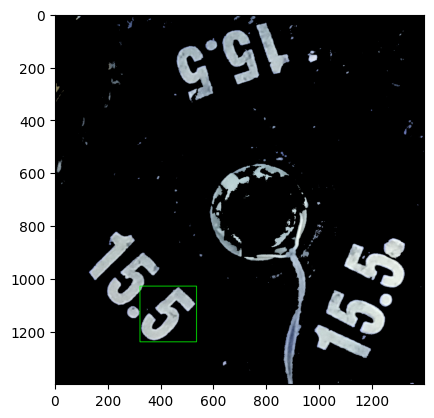

In [223]:
def getContours(image):
    thresh = cv2.adaptiveThreshold(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 7)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def getNumberPos(image):
    contours=getContours(image)
    number_positions=[]

    for contour in contours:
        area = cv2.contourArea(contour)
        x, y, w, h = cv2.boundingRect(contour)

        if (
            area > 1000
            and 1 < w / h < 1.2
            and h > 200 and h <= 300
        ):
            number_positions.append({'pos':(x,y),'cnt': contour})
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    return number_positions

number_positions=getNumberPos(cropped_image)
plt.imshow(cropped_image)


Track the contours near these positions.

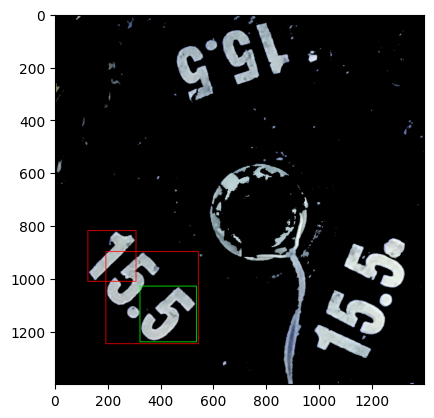

In [224]:
def getNearbyContours(image, posList, contours):
    # Set the maximum distance threshold to filter contours
    max_distance = 200

    # Filter contours near the point of interest
    filtered_contours = []

    for cntData in posList:
        point_of_interest=cntData['pos']
        for cnt in contours:
             # Calculate the contour area
            area = cv2.contourArea(cnt)
            x, y, w, h = cv2.boundingRect(cnt)

            if area > 1000:
                # Calculate the distance between the contour centroid and the point of interest
                M = cv2.moments(cnt)
                cx = int(M['m10'] / M['m00'])
                cy = int(M['m01'] / M['m00'])
                distance = np.sqrt((cx - point_of_interest[0])**2 + (cy - point_of_interest[1])**2)

                # Retain the contour if it falls within the distance threshold
                if distance <= max_distance:
                    filtered_contours.append({'pos':(x,y),'cnt': cnt})
                    cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)

    return filtered_contours


nearby_contours = getNearbyContours(cropped_image, number_positions, getContours(cropped_image))
plt.imshow(cropped_image)

In [225]:
def findAngle(x,y,w,h):
    rect_center_x = x + w // 2
    rect_center_y = y + h // 2
    img_center_x = cropped_image.shape[1] // 2
    img_center_y = cropped_image.shape[0] // 2
    # distance = np.sqrt((rect_center_x - img_center_x) ** 2 + (rect_center_y - img_center_y) ** 2)
    ref_point_x = img_center_x
    ref_point_y = rect_center_y
    distance_yellow_to_orange = np.sqrt((ref_point_x - img_center_x) ** 2 + (ref_point_y - img_center_y) ** 2)
    distance_red_to_orange = np.sqrt((ref_point_x - rect_center_x) ** 2 + (ref_point_y - rect_center_y) ** 2)
    # print(f" Distance btw red to orange : {distance_red_to_orange}")
    # print(f" Distance btw yellow to orange : {distance_yellow_to_orange}")
    radians= np.arctan(distance_red_to_orange/distance_yellow_to_orange)
    angle= np.degrees(radians)
    print(f"Angle : {angle}")
    plt.imshow(cropped_image)
    plt.scatter(rect_center_x,rect_center_y,c='red')
    plt.scatter(img_center_x,img_center_y,c='green')
    plt.scatter(ref_point_x,ref_point_y,c='orange')
    return angle    

Filter out the overlapping contours. Extract the images with numbers.

Angle : 41.83367348099653


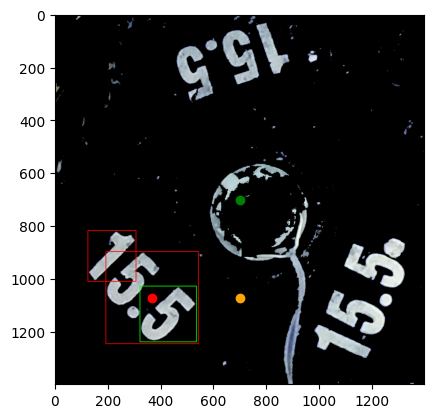

In [226]:
rotated_image = originalImage
def check_contour_overlap(contour1, contour2):
    # Get the bounding rectangles of the contours
    x1, y1, w1, h1 = cv2.boundingRect(contour1)
    x2, y2, w2, h2 = cv2.boundingRect(contour2)

    # Calculate the coordinates of the top-left and bottom-right corners of the rectangles
    rect1_tl = (x1, y1)
    rect1_br = (x1 + w1, y1 + h1)
    rect2_tl = (x2, y2)
    rect2_br = (x2 + w2, y2 + h2)

    # Check if the rectangles intersect
    if rect1_tl[0] < rect2_br[0] and rect1_br[0] > rect2_tl[0] and rect1_tl[1] < rect2_br[1] and rect1_br[1] > rect2_tl[1]:
        return True  # Contours overlap
    else:
        return False  # Contours do not overlap
    
def filterNumberImages(image, number_positions, nearby_contours):
    img_counter=0        
    extract_images=[]

    for parentCntData in nearby_contours:
        for childCntData in number_positions:
            if(check_contour_overlap(parentCntData['cnt'],childCntData['cnt'])):
                img_counter+=1
                x, y, w, h = cv2.boundingRect(parentCntData['cnt'])
                if x < 800 and y > 800 :
                    global rotated_image

                    angle = findAngle(x,y,w,h)
                    rows, cols = cropped_image.shape[:2]
                    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
                    rotated_image = cv2.warpAffine(originalImage, M, (cols, rows))
                    # plt.imshow(rotated_image)
                    # plt.show()
                    break
                extract_image = originalImage[y:y+h, x:x+w]
                extract_images.append(extract_image)
    return extract_images


def displayImages(images):
    for img in images:
        plt.imshow(img)
        plt.show()

extract_images=filterNumberImages(cropped_image, number_positions, nearby_contours)
# print(f'Number of images extracted: {len(extract_images)}')
#displayImages(extract_images)

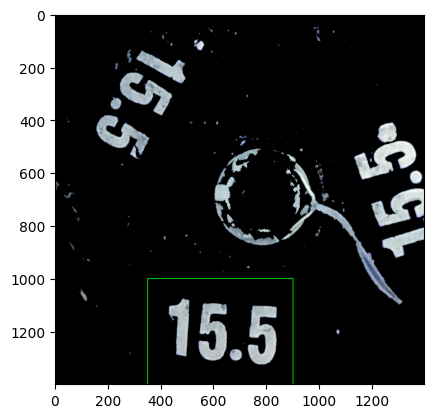

In [227]:
img_copy_2= np.copy(rotated_image)
cv2.rectangle(img_copy_2,(350,1000),(900,1450),(0, 255, 0), 2)
plt.imshow(img_copy_2)

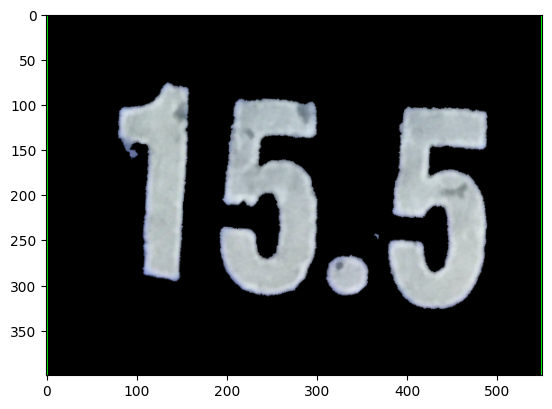

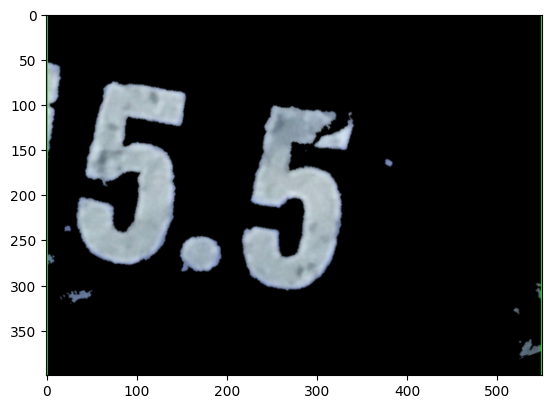

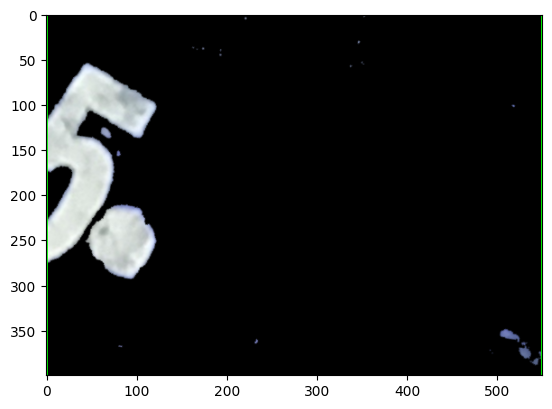

In [228]:
img_copy= np.copy(rotated_image)
angle = 0
cropped_number_image =[]
for i in range(0,3):
    rows, cols = img_copy.shape[:2]
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    rotated_image_copy = cv2.warpAffine(img_copy, M, (cols, rows))
    angle+=110
    cv2.rectangle(rotated_image_copy,(350,1000),(900,1450),(0, 255, 0), 2)
    cropped_number =rotated_image_copy[1000:1450,350:900]
    cropped_number_image.append(cropped_number)

displayImages(cropped_number_image)

In [229]:
test_img = cropped_number_image[0]
test_array = [0,1,2,3,4,5]
location_dictionary ={}
for number in test_array :
    template = cv2.imread(f'../images/digits/{number}.jpg')
    method = cv2.TM_CCOEFF_NORMED
    result = cv2.matchTemplate(test_img, template, method)
    threshold = 0.5
    best_match = np.max(result)
    if best_match >= threshold:
        print(number)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        top_left = max_loc
        x_location = top_left[0]
        location_dictionary[f'{number}']=x_location
    # Extract and sort the numbers based on their x-axis position
print(location_dictionary)
sorted_keys = [k for k, v in sorted(location_dictionary.items(), key=lambda item: item[1])]
print(sorted_keys)

1
4
{'1': 235, '4': 94}
['4', '1']


1


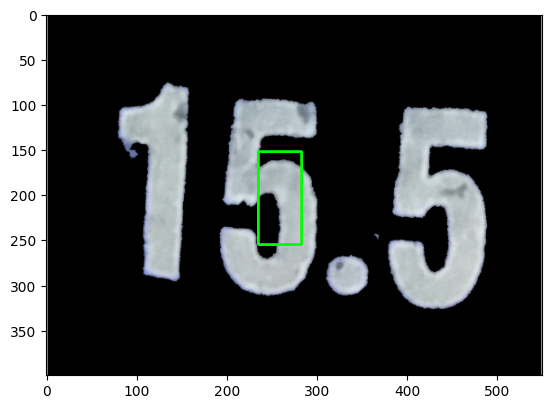

In [230]:
test_img = cropped_number_image[0]
test_array = [1,3,5]
num =[]

for number in test_array :
    template = cv2.imread(f'../images/template/{number}.jpg')
    method = cv2.TM_CCOEFF_NORMED
    result = cv2.matchTemplate(test_img, template, method)

    threshold = 0.6
    best_match = np.max(result)
    if best_match >= threshold:
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        top_left = max_loc
        h, w = template.shape[:2]
        bottom_right = (top_left[0] + w, top_left[1] + h)
        cv2.rectangle(test_img, top_left, bottom_right, (0,255,0), 2)
        print(number)
plt.imshow(test_img)


In [64]:
import re

def remove_special_characters_and_letters(input_string):
    # Remove special characters and letters using regular expressions
    cleaned_string = re.sub('[^0-9]', '', input_string)
    return cleaned_string

['Error', 15.3, 15.3]


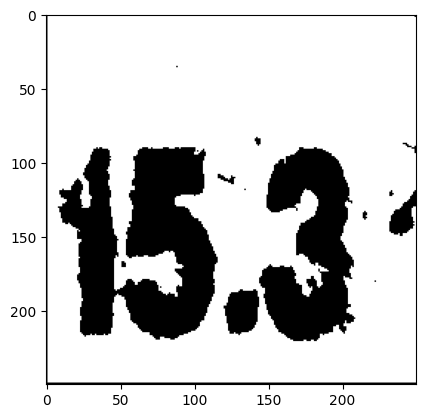

In [87]:
test_img = cropped_number_image[0]
numbers_predicted=[]
for test_img in cropped_number_image:
    new_img =cv2.resize(test_img,(250,250))
    gray = cv2.cvtColor(new_img,cv2.COLOR_RGB2GRAY)
    arr=np.array(gray)
    for rows in range(len(arr[0])):
        for cols in range(len(arr)):
            if arr[rows][cols] <100 :
                arr[rows][cols] = 255
            else :
                arr[rows][cols]= 0
    color =cv2.cvtColor(arr,cv2.COLOR_GRAY2RGB)
    plt.imshow(color)
    recognized_text=pytesseract.image_to_string(color,config='--psm 11 --oem 3 ')
    number = remove_special_characters_and_letters(recognized_text)
    if number == '' or float(number)<20 :
        actual_number = 'Error'
    elif float(number) < 100 :
        actual_number = float(number)/10+10

    else :
        actual_number = float(number)/10
    numbers_predicted.append(actual_number)
    
    # if(recognized_text==''):
    #     numbers_predicted.append('Error')
    # else:
    #     numbers_predicted.append(float(recognized_text))
print(numbers_predicted)


In [75]:
from collections import Counter

def print_max_occurrence(items):
    # Count the occurrences of each item in the list
    counter = Counter(items)

    # Get the most common item and its occurrence
    most_common_item, occurrence = counter.most_common(1)[0]

    # Print the most common item and its occurrence
    print(f"The most likely weight is {most_common_item}kg with a probability of {round(occurrence/3,3)*100}%.")

print_max_occurrence(numbers_predicted)

The most likely weight is 15.3kg with a probability of 66.7%.


In [107]:
numbers_predicted=[]
print('\n')
for img in cropped_number_image:
    recognized_text=pytesseract.image_to_string(img,config='--psm 6 --oem 3 ')

    if(recognized_text==''):
        numbers_predicted.append('Error')
    else:
        numbers_predicted.append(float(recognized_text))
print(numbers_predicted)
print('\n')



['Error', 15.3, 'Error']




TesseractError: (1, 'Estimating resolution as 1772 Too few characters. Skipping this page Warning. Invalid resolution 0 dpi. Using 70 instead. Too few characters. Skipping this page Error during processing.')

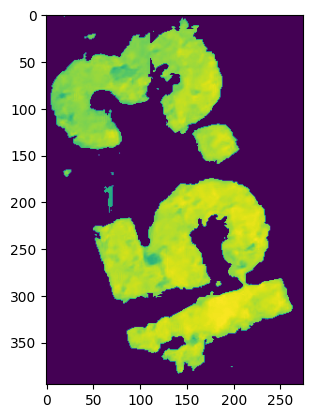

In [73]:
for images in extract_images :
        gray = cv2.cvtColor(images, cv2.COLOR_BGR2GRAY)
        plt.imshow(gray)
        data = pytesseract.image_to_osd(gray, config='--psm 0 ')
        rotation_angle = int(data.split('Rotate: ')[-1])
        print(rotation_angle)
        break

Align the number images straight before processing.

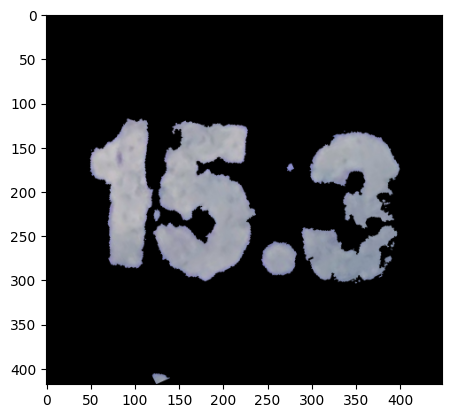

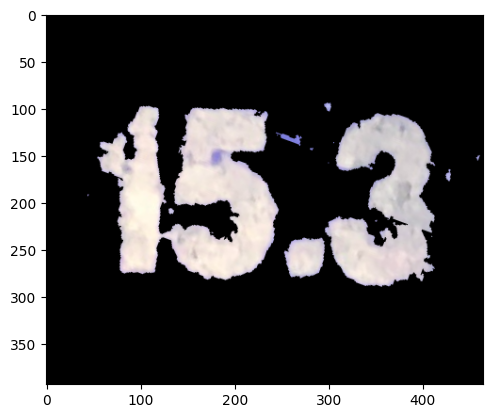

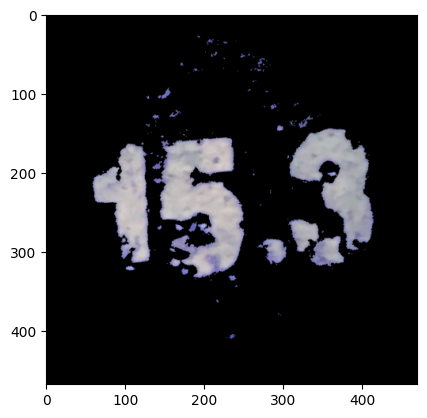

In [ ]:
def rotate_image(image, angle):
    # Get the dimensions of the image
    height, width = image.shape[:2]

    # Calculate the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1)

    # Calculate the new dimensions of the rotated image
    cos_theta = np.abs(rotation_matrix[0, 0])
    sin_theta = np.abs(rotation_matrix[0, 1])
    new_width = int(height * sin_theta + width * cos_theta)
    new_height = int(height * cos_theta + width * sin_theta)

    # Adjust the rotation matrix to accommodate the new dimensions
    rotation_matrix[0, 2] += (new_width - width) / 2
    rotation_matrix[1, 2] += (new_height - height) / 2

    # Perform the rotation with the adjusted rotation matrix
    rotated_image = cv2.warpAffine(image, rotation_matrix, (new_width, new_height))

    return rotated_image

    return rotated_image

def alignedNumberImages(image_list):
    rotatedNumberImages=[]
    i=0
    for img in image_list:
        rotatedImg=img
        if(i==0):
            rotatedImg = rotate_image(img, 25)
        elif(i==1):
            rotatedImg = rotate_image(img, -110)
        elif(i==2):
            rotatedImg = rotate_image(img, 140)

        rotatedNumberImages.append(rotatedImg)
        i+=1

    return rotatedNumberImages



aligned_extract_images=alignedNumberImages(extract_images)
displayImages(aligned_extract_images)

Read the numbers and come to a conclusion

15.2



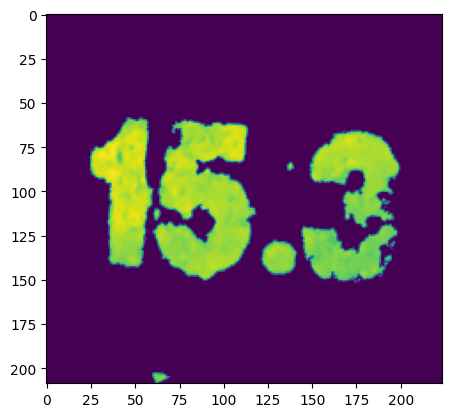

In [ ]:
for img in aligned_extract_images:

    np.set_printoptions(threshold=np.inf)
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    image_shape = gray_image.shape
    new_shape = (224,209)
    resized_image = cv2.resize(gray_image, new_shape)
    image_shape=resized_image.shape
    plt.imshow(resized_image)
    recognized_text=pytesseract.image_to_string(resized_image,config='--psm 4 --oem 1 ')
    print(recognized_text)
    # arr=np.array(resized_image)
    # print(arr[25])
    # plt.imshow(arr)
    break


In [ ]:
# numbers_predicted=[]
# for img in aligned_extract_images:
#     recognized_text=pytesseract.image_to_string(img,config='--psm 10 --oem 3 -c tessedit_char_whitelist=0123456789')
#     numbers_predicted.append(int(recognized_text.strip())/10)

# def processOutput(numbers_predicted):
#     unique_elments=set(numbers_predicted)
#     if(len(unique_elments)>1):
#         return 0

# weight=processOutput(numbers_predicted)
# print(f'Weight of cylinder: {weight}')